Feature engineering cumulative impact
================================
*A companion notebook of R code to the articles:*

* [Part I](TBD)
* [Part II](TBD)

# Part I

In [1]:
library(dplyr)
library(splines)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Movitating Articles

[Fatigue and fitness modelled from the effects of training on performance](https://www.researchgate.net/profile/Robin_Candau/publication/15242395_Fatigue_and_fitness_modelled_from_the_effects_of_training_on_performance/links/55720f2608ae7536374cdc09/Fatigue-and-fitness-modelled-from-the-effects-of-training-on-performance.pdf) (Busso, Candau, and Lacour 1994, referred to as "BCL94" in the companion article

[Modeling human performance in running](https://www.researchgate.net/publication/20910238_Modeling_human_performance_in_running) (Morton, Clarke and Banister 1990)

[Convolution notes from MIT's Jeremy Orloff](https://math.mit.edu/~jorloff/suppnotes/suppnotes03/i.pdf)


Average training intensity during build up phase: 33.6 
Average training intensity during competition phase: 23.32

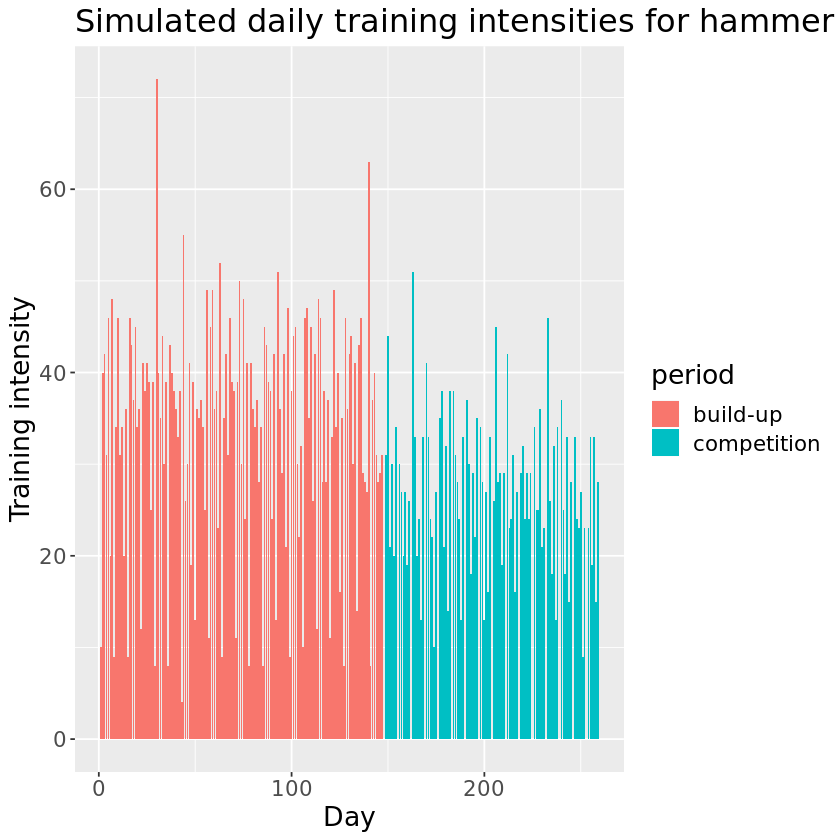

In [2]:
train_df <- data.frame(day = 1:259, day_of_week = 0:258 %% 7)
train_df$period <- ifelse(train_df$day <= 147, "build-up", "competition")
train_df$w <- with(train_df, w <-
  -24 * (day_of_week == 0) +
   12 * (day_of_week == 1) +
    8 * (day_of_week == 2) +
    0 * (day_of_week == 3) +
    6 * (day_of_week == 4) +
   -8 * (day_of_week == 5) +
    6 * (day_of_week == 6))

set.seed(1523)
train_df$w <- rpois(nrow(train_df),
                    train_df$w + ifelse(train_df$period == "build-up", 34, 24))

cat("Average training intensity during build up phase:",
    round(mean(train_df$w[train_df$day <= 147]), 2), "\n")
cat("Average training intensity during competition phase:",
    round(mean(train_df$w[train_df$day > 147]), 2))

ggplot(train_df, aes(x = day, y = w)) +
  geom_bar(aes(fill = period), stat = "identity") +
  ggtitle("Simulated daily training intensities for hammer thrower") +
  xlab("Day") + ylab("Training intensity") +
  theme(text = element_text(size = 16))


Fitness and Fatigue follow Exponential Decay: $g(t) = k \exp(-t / τ)$

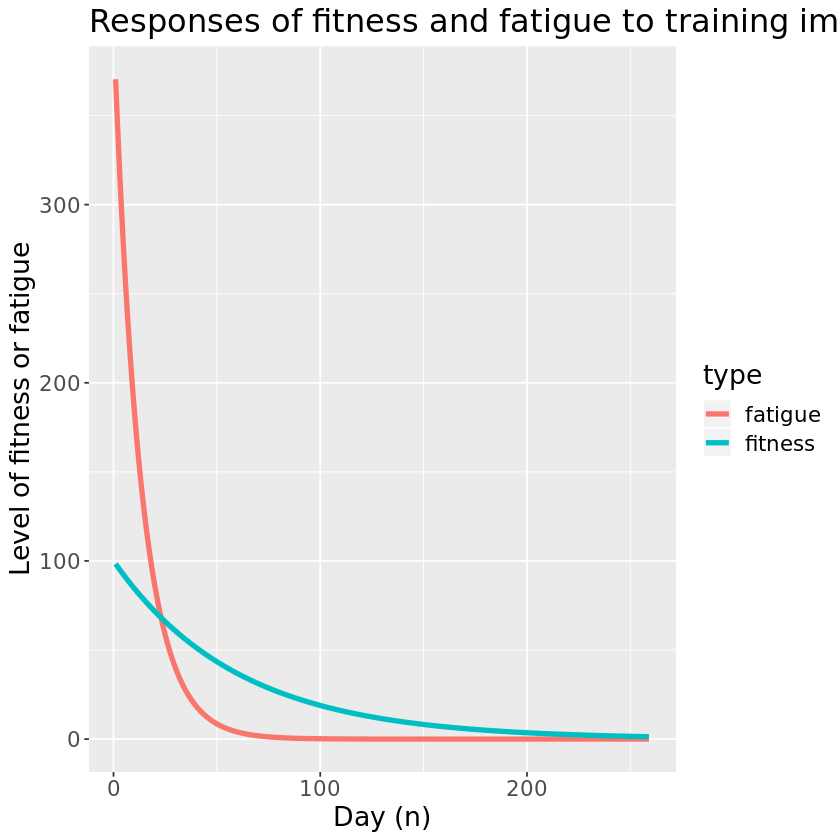

In [3]:
# Exponential decay and fitness-fatigue profiles
exp_decay <- function(t, tau) {
  exp(-t / tau)
}

grid_df <- rbind(data.frame(day = 1:259, level = 400 * exp_decay(1:259, 13),
                            type = "fatigue"),
                 data.frame(day = 1:259, level = 100 * exp_decay(1:259, 60),
                            type = "fitness"))

ggplot(grid_df, aes(x = day, y = level)) +
  geom_line(aes(color = type), size = 1.5) +
  ggtitle("Responses of fitness and fatigue to training impulse") +
  xlab("Day (n)") + ylab("Level of fitness or fatigue") +
  theme(text = element_text(size = 16))


The effect of either fitness or fatigue at a given point in time is expressed as a convolution
of the training history with the relevant decay function:
$$
\sum_{i=1}^{n-1} w_i \exp \left(\frac{-(n-i)}{\tau} \right)
$$

In [4]:
convolve_training <- function(training, n, tau) {
  sum(training[1:(n - 1)] * exp_decay((n - 1):1, tau))
}

fitness <- sapply(1:nrow(train_df),
                  function(n) convolve_training(train_df$w, n, 60))

fatigue <- sapply(1:nrow(train_df),
                  function(n) convolve_training(train_df$w, n, 13))


The final expected performance function for our simulated hammer thrower is:
$$
\text{E}(p_n) = 496 + 0.07 \sum_{i=1}^{n-1} w_i \exp \left(\frac{-(n-i)}{60} \right) - 0.27 \sum_{i=1}^{n-1} w_i \exp \left(\frac{-(n-i)}{13} \right) 
$$

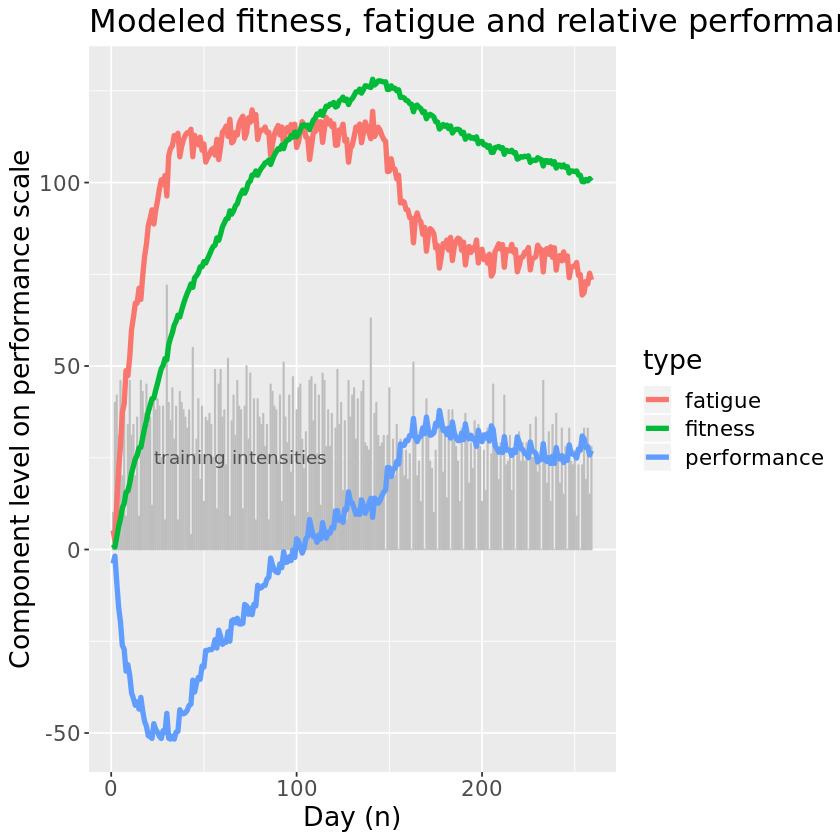

In [5]:
E_perf <- 496 + .07 * fitness - .27 * fatigue

set.seed(45345)
train_df$perf <- E_perf + 7.0 * rnorm(nrow(train_df))

components_df <- rbind(
  data.frame(level = .27 * fatigue, day = train_df$day, type = "fatigue"),
  data.frame(level = .07 *fitness, day = train_df$day, type = "fitness"),
  data.frame(level = E_perf - 496, day = train_df$day, type = "performance"))

ggplot(components_df, aes(x = day, y = level)) +
  geom_col(data = train_df, aes(x = day, y = w), color = "grey", width = .2) +
  geom_line(aes(color = type), size = 1.5) +
  annotate("text", label = "training intensities", x = 70, y = 25,
           color = "grey32") +
  ggtitle("Modeled fitness, fatigue and relative performance") +
  xlab("Day (n)") + ylab("Component level on performance scale") +
  theme(text = element_text(size = 16))

In [6]:
# Recover parameters using non-linear regression
rss <- function(theta) {
  int  <- theta[1] # performance baseline
  k1   <- theta[2] # fitness weight
  k2   <- theta[3] # fatigue weight
  tau1 <- theta[4] # fitness decay
  tau2 <- theta[5] # fatigue decay

  fitness <- sapply(1:nrow(train_df),
                    function(n) convolve_training(train_df$w, n, tau1))

  fatigue <- sapply(1:nrow(train_df),
                    function(n) convolve_training(train_df$w, n, tau2))

  perf_hat <- int + k1 * fitness - k2 * fatigue
  return(sum((train_df$perf - perf_hat) ^ 2))
}


optim_results <- optim(c(400, .05, .15, 20, 5), rss, method = "BFGS",
                       hessian = TRUE, control = list(maxit = 1000))
                    
print(optim_results$convergence) # 0 means algorithm as converged

[1] 0


In [7]:
VarCov <- solve(optim_results$hessian)
parm_names <- c("baseline", "fitness weight", "fatigue weight",
                "fitness time const", "fatigue time const")
for (i in 1:5) {
  cat(parm_names[i], "estimate:", round(optim_results$par[i], 2),
      ", std.err.:", round(sqrt(diag(VarCov))[i], 2), "\n")
}

baseline estimate: 492.35 , std.err.: 0.31 
fitness weight estimate: 0.07 , std.err.: 0 
fatigue weight estimate: 0.26 , std.err.: 0 
fitness time const estimate: 59.11 , std.err.: 0.5 
fatigue time const estimate: 13.86 , std.err.: 0.16 


In [8]:
get_performance <- function(theta) {
  int  <- theta[1] # performance baseline
  k1   <- theta[2] # fitness weight
  k2   <- theta[3] # fatigue weight
  tau1 <- theta[4] # fitness decay
  tau2 <- theta[5] # fatigue decay

  fitness <- sapply(1:nrow(train_df),
                    function(n) convolve_training(train_df$w, n, tau1))

  fatigue <- sapply(1:nrow(train_df),
                    function(n) convolve_training(train_df$w, n, tau2))

  int + k1 * fitness - k2 * fatigue
}
                    
train_df$perf_hat <- get_performance(optim_results$par)


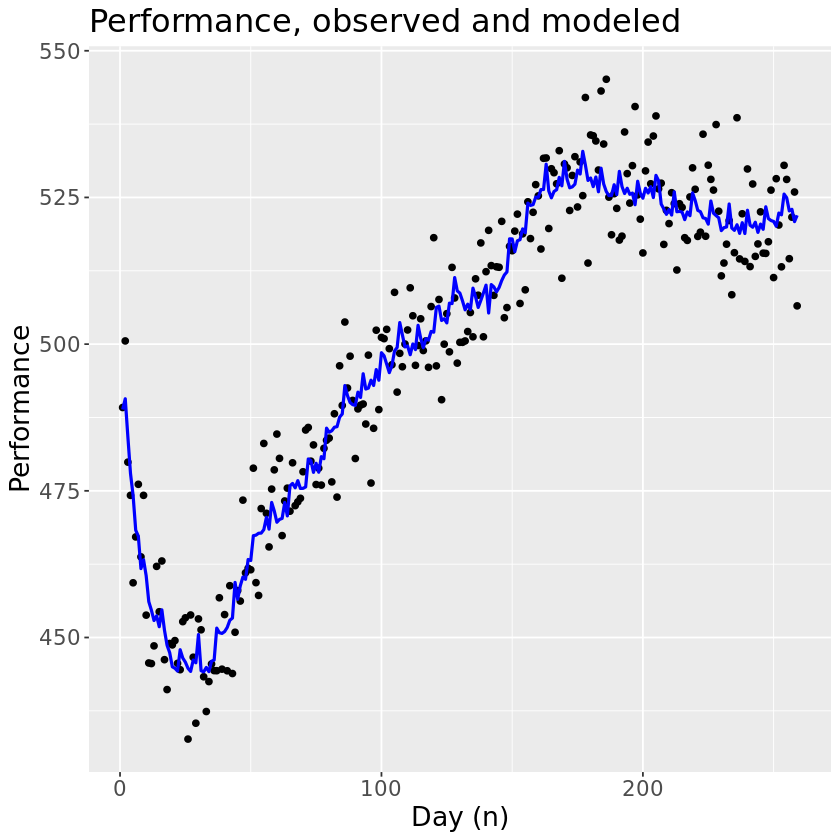

In [9]:
ggplot(train_df) +
  geom_point(aes(x = day, y = perf)) +
  geom_line(aes(x = day, y = perf_hat), color = "blue", size = .9) +
  ggtitle("Performance, observed and modeled") +
  xlab("Day (n)") + ylab("Performance") +
  theme(text = element_text(size = 16))

# Part II
<a id='spline-math'></a>
## Using splines to approximate the decay function

In Part I, we had *fitness* and *fatigue* features of the form:
$$
\sum_{i=1}^{n-1} w_i \exp \left(\frac{-(n-i)}{\tau} \right),
$$
where the exponential decay of both fitness and fatige from initial levels arose from a first order linear dynamic system. But what if that model is not right? Suppose instead that the true "decay function," which I'll hereby refer to as a "lag distribution" (See [Sims 1971](https://www.jstor.org/stable/1913265?seq=1#page_scan_tab_contents)) since it might be strictly decreasing, is an arbitrary smooth, continuous function $f(x)$. As a smooth, continuous function, $f(x)$ is a good candidate for approximation via basis functions taking the form
$$
\eta(t) = \theta_1 + \sum_{j=2}^p \theta_j g_j(t),
$$
and in this article we'll consider parametric B-splines for the job. 

Consider our general purpose convolution-based feature
$$r_s = \sum_{i = 1} ^ {s-1} w_i \eta(s - i), s = 1, \ldots n$$.

Expanding $\eta(t)$ leads to
$$
r_s = \theta_1 \sum_{i=1}^{s-1}  w_i + \sum_{j=2}^p \theta_j \sum_{i = 1}^{s-1} w_i g_j(s-i).
$$

Thus, implementing this convolution based feature amounts to a linear regression with the following $p$ covariates:

\begin{align*}
z_1 &= \sum_{i=1}^{s-1} w_i, \\
z_j &= \sum_{i = 1}^{s-1} w_i g_j(s-i), \; j = 2, \ldots, p.
\end{align*}

Having multiple convolution based covariates based on training intensity is reminiscent of *fitness* and *fatigue*, which were exponentials with different decay time constants convolved with training intensity. However, even if the fitness fatigue model holds exactly, we'd only need one spline function to convolve with training input. This is because use of the two separate fitness and fatigue convolutions is equivalent to convolving training intensity with function
$$
r_n = 0.07 \exp (-n / 60) - 0.27 \exp(-n / 13),
$$
which involves rearranging terms in the original regression and using linearity of the summation. This function is *not* exponential decay:



Call:
lm(formula = get_true_phi(days_grid) ~ my_spline)

Coefficients:
(Intercept)   my_spline1   my_spline2   my_spline3   my_spline4  
    -0.1646       0.1909       0.1014       0.3221       0.0756  



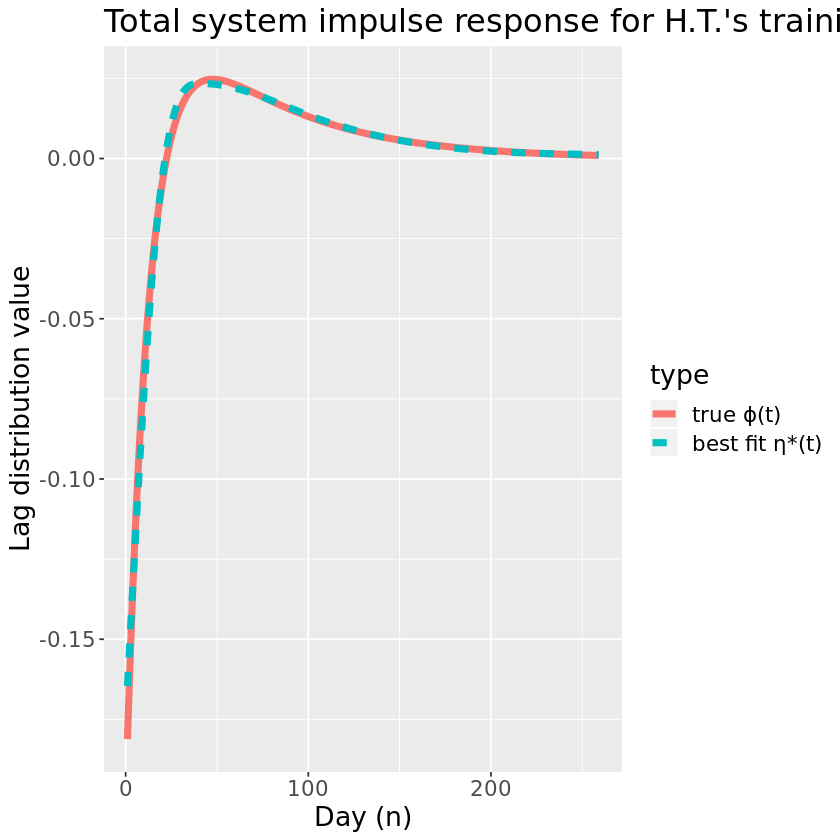

In [23]:
library(splines)

exp_decay <- function(t, tau) {
  exp(-t / tau)
}

get_true_phi <- function(t) {
  0.07 * exp_decay(t, 60) - 0.27 * exp_decay(t, 13)
}
days_grid <- 1:259
my_spline <- ns(days_grid, Boundary.knots = c(1, 259), knots = c(14, 40, 100))

eta_star_lm <- lm(get_true_phi(days_grid) ~ my_spline)
print(eta_star_lm)

eta_star <- fitted(eta_star_lm)

# Figure 1
plot_df <- rbind(
  data.frame(day = days_grid, level = phi, type = "true \u03D5(t)"),
  data.frame(day = days_grid, level = eta_star, type = "best fit \u03B7*(t)")
)

ggplot(plot_df, aes(x = day, y = level, color = type, linetype = type)) +
  geom_line(size = 2) +
  ggtitle("Total system impulse response for H.T.'s training") +
  xlab("Day (n)") + ylab("Lag distribution value") +
  theme(text = element_text(size = 16))


## Spline approximation
Notice that in addition to plotting the system impulse response function, whose convolution with H.T.'s training intensities is equivalent to the weighted impact of both fitness and fatigue convolutions in the original regression, there is also a spline approximation that has been plotted. The approximation is pretty good, and, full disclosure: I purposefully searched for a knot configuration that was both simple and sufficient given my knowledge of the true function (which would not be known exactly in advance).

The point is, given a reasonable collection of basis functions for the system impulse response, the following method will work. In the parametric spline situation, if the analyst is less confident about where the knots should go, more interior knots could be chosen at the expense of complexity and variability of estimation. For our choice of parametric spline with interior knots at days 14, 40 and 100, we have the following basis functions:

In [12]:
head(my_spline)

1,2,3,4
0.0000000000,0.00000000,0.00000000,0.00000000
0.0000199231,-0.01912323,0.04546278,-0.02633955
0.0001593848,-0.03813129,0.09065175,-0.05252046
0.0005379236,-0.05690900,0.13529309,-0.07838409
0.0012750782,-0.07534118,0.17911299,-0.10377181
0.0024903871,-0.09331265,0.22183763,-0.12852498


The regression of true impulse response against the basis functions gives us estimates of $\theta_1, \ldots, \theta_5$ from the definition of $\eta$ above.

In [13]:
print(my_lm)


Call:
lm(formula = plot_df$level ~ my_spline)

Coefficients:
(Intercept)   my_spline1   my_spline2   my_spline3   my_spline4  
    -0.1646       0.1909       0.1014       0.3221       0.0756  



Thus, if we can recover these coefficients from the spline basis functions (that depend only on the knot locations), the training impulses, and the observed performance measurements, then we've suceeded in fitting a non-parametric version of the fitness fatigue model that closely approximates its parametric counterpart.

The next step is to create the $z_1, \ldots, z_5$ variables as described above:

In [14]:
z_vars <- list()
for (n in 1:nrow(train_df)) {
  spline_pred <- predict(my_spline, newx = (n - 1):1)
  spline_vars <- colSums(spline_pred * train_df$w[1:(n - 1)]) # convolution
  spline_const <- sum(train_df$w[1:(n - 1)])
  z_vars[[n]] <- c(spline_const, spline_vars)
}

z_vars_df <- Reduce(rbind.data.frame, z_vars)
names(z_vars_df) <- paste0("z_", 1:ncol(z_vars_df))
head(z_vars_df)

z_1,z_2,z_3,z_4,z_5
10,0.000000000,0.1914243,-0.4550842,0.2636599
10,0.000000000,0.0000000,0.0000000,0.0000000
50,0.000199231,-0.1912323,0.4546278,-0.2633955
92,0.002390772,-1.1462423,2.7250288,-1.5787865
123,0.012591397,-2.8975175,6.8884377,-3.9909203
169,0.041579503,-5.2241062,12.4195732,-7.1954670


In [16]:
train_aug_df <- cbind(train_df, z_vars_df)

spline_reg <- lm(perf ~ z_1 + z_2 + z_3 + z_4 + z_5, data = train_aug_df)
summary(spline_reg)
train_aug_df$perf_hat <- spline_reg$fitted


Call:
lm(formula = perf ~ z_1 + z_2 + z_3 + z_4 + z_5, data = train_aug_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-16.6576  -4.3120  -0.0274   4.1162  18.6338 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 491.668936   2.947533  166.81   <2e-16 ***
z_1          -0.153090   0.012525  -12.22   <2e-16 ***
z_2           0.177312   0.011952   14.84   <2e-16 ***
z_3           0.096656   0.007135   13.55   <2e-16 ***
z_4           0.301346   0.026191   11.51   <2e-16 ***
z_5           0.066427   0.005505   12.07   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.965 on 253 degrees of freedom
Multiple R-squared:  0.9408,	Adjusted R-squared:  0.9396 
F-statistic: 803.5 on 5 and 253 DF,  p-value: < 2.2e-16


In [17]:
head(train_aug_df$perf_hat)

[1] 490.0369 490.1380 484.1155 478.1905 474.3717 468.5637

In [24]:
get_eta_hat <- function(t_seq) {
  spline_vars_grid <- predict(my_spline, newx = t_seq)
  spline_vars_grid <- cbind(1, spline_vars_grid)
  eta_hat <- spline_vars_grid %*% coef(spline_reg)[-1]
  as.numeric(eta_hat)
}

convolve_with_fn <- function(training, n, impulse_fn) {
  sum(training[1:(n - 1)] * impulse_fn((n - 1):1))
}

cumulative_impact_eta <- sapply(1:nrow(train_df),
                                function(n) convolve_with_fn(train_df$w, n,
                                                             get_eta_hat))
cumulative_impact_phi <- sapply(1:nrow(train_df),
                                function(n) convolve_with_fn(train_df$w, n,
                                                             get_true_phi))

train_aug_df$perf_hat_convo_eta <- coef(spline_reg)[1] + cumulative_impact_eta
train_aug_df$perf_hat_fitness_fatigue <- 496 + cumulative_impact_phi

# Removing end effects, convolving with spline is same as regression fitted vals
cat("Is convolving with spline eta is equivalent to regression fitted vals?")
all(abs(train_aug_df$perf_hat_convo_eta  - train_aug_df$perf_hat)[-1] < .001)

days_grid <- 1:259
eta_hat <- get_eta_hat(days_grid)
phi <- get_true_phi(days_grid)

Is convolving with spline eta is equivalent to regression fitted vals?

[1] TRUE

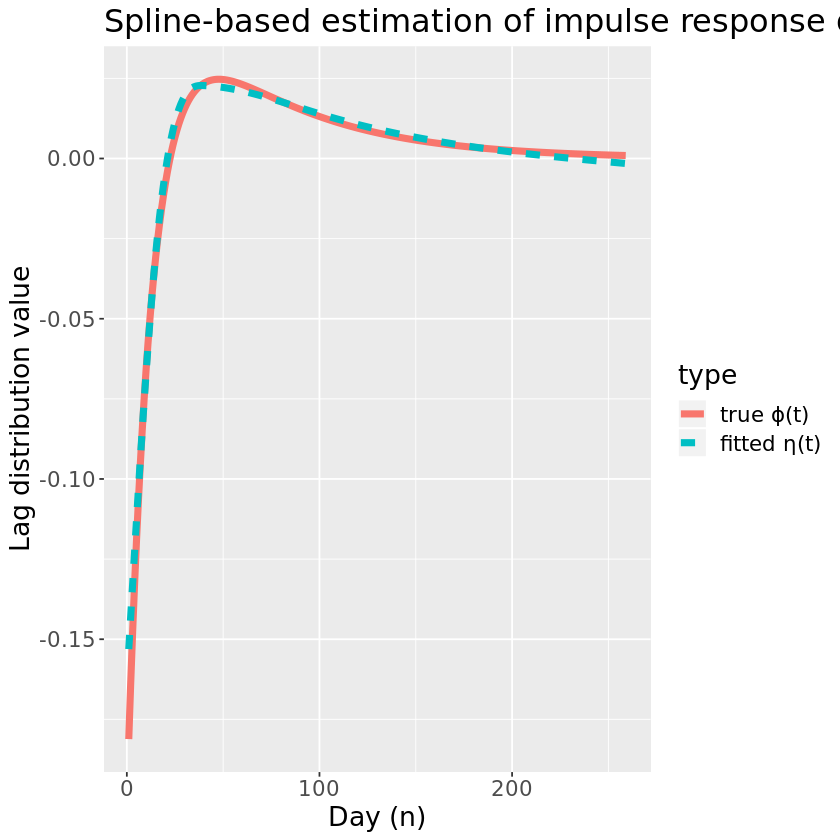

In [25]:
# Figure 2
plot_df <- rbind(
  data.frame(day = days_grid, level = phi, type =  "true \u03D5(t)"),
  data.frame(day = days_grid, level = eta_hat, type = "fitted \u03B7(t)")
)

ggplot(plot_df, aes(x = day, y = level, color = type, linetype = type)) +
  geom_line(size = 2) +
  ggtitle("Spline-based estimation of impulse response \u03D5(t)") +
  xlab("Day (n)") + ylab("Lag distribution value") +
  theme(text = element_text(size = 16))

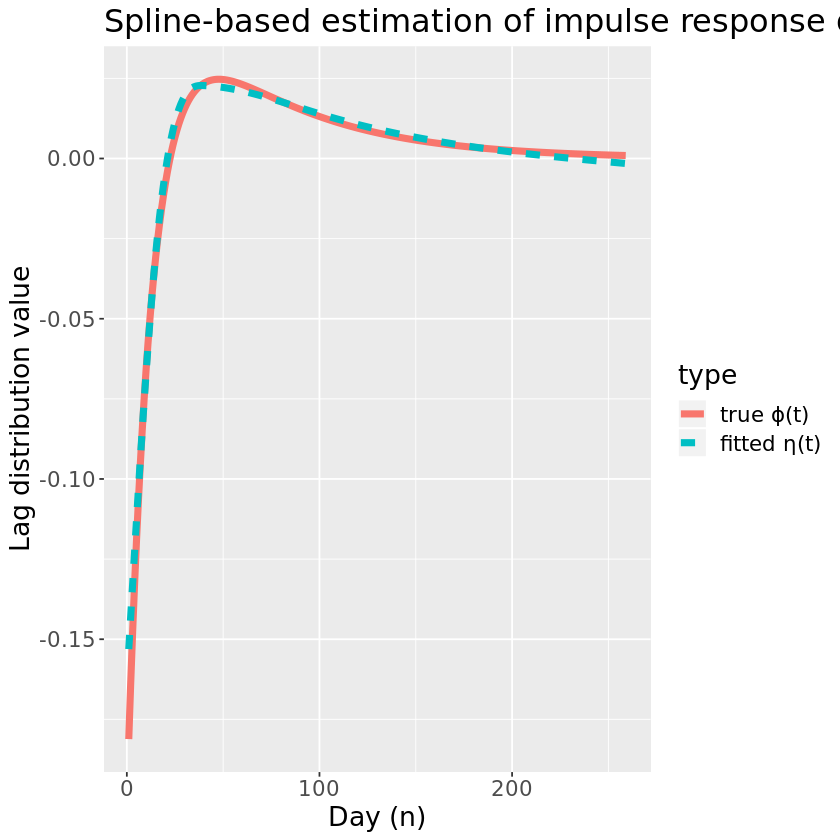

In [26]:
# Figure 2
plot_df <- rbind(
  data.frame(day = days_grid, level = phi, type =  "true \u03D5(t)"),
  data.frame(day = days_grid, level = eta_hat, type = "fitted \u03B7(t)")
)

ggplot(plot_df, aes(x = day, y = level, color = type, linetype = type)) +
  geom_line(size = 2) +
  ggtitle("Spline-based estimation of impulse response \u03D5(t)") +
  xlab("Day (n)") + ylab("Lag distribution value") +
  theme(text = element_text(size = 16))

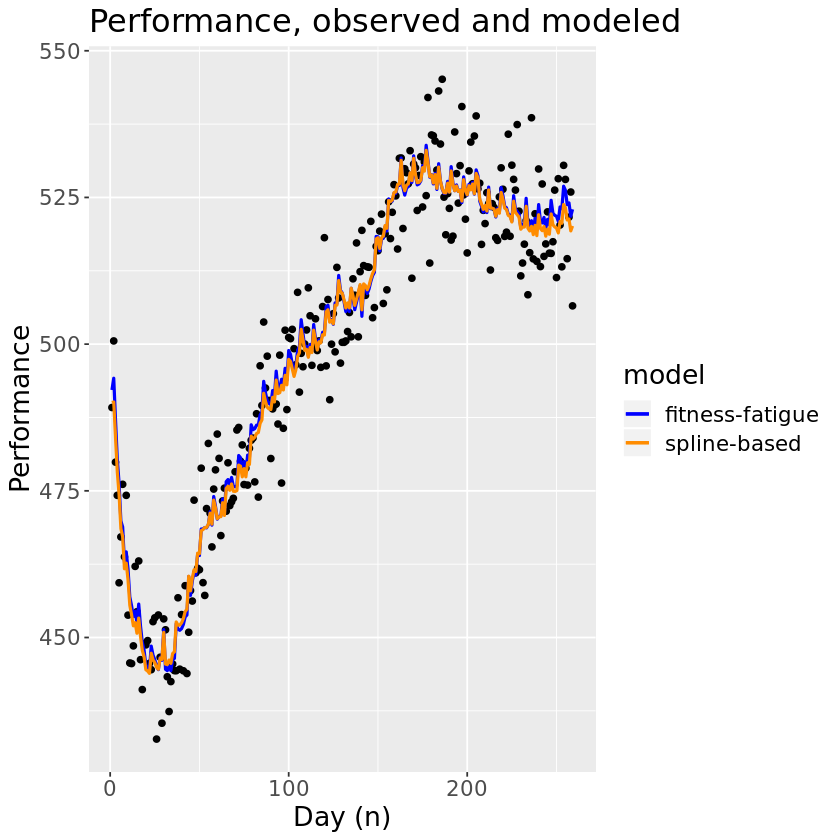

In [27]:
# Figure 3
ggplot(train_aug_df) +
  geom_point(aes(x = day, y = perf)) +
  geom_line(aes(x = day, y = perf_hat_fitness_fatigue, color = "blue"),
            size = .9) +
  geom_line(aes(x = day, y = perf_hat, color = "dark orange"), size = .9) +
  ggtitle("Performance, observed and modeled") +
  xlab("Day (n)") + ylab("Performance") +
  theme(text = element_text(size = 16)) +
  scale_colour_manual(name = "model",
    values =c("blue" = "blue","dark orange" = "dark orange"),
    labels = c("fitness-fatigue", "spline-based"))